In [1]:
import matplotlib
matplotlib.use('Agg')

import numpy as np
import collections
from functools import partial
from os.path import expanduser
from tqdm import tqdm
import h5py

from surround.image_processing import *
from surround.data_handling import *
from surround.efficient_coding import *
from aesthetics.plotting import *
from surround.modeling import gaussian, difference_of_gaussians

import pyret.filtertools as ft
from sklearn.decomposition import PCA
from scipy.stats import sem
from scipy.optimize import curve_fit, minimize
from scipy.interpolate import interp1d

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

plt.style.use('deepretina')

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

/home/lane/.local/lib/python3.5/site-packages/matplotlib-2.0.0-py3.5-linux-x86_64.egg/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/home/lane/.local/lib/python3.5/site-packages/matplotlib-2.0.0-py3.5-linux-x86_64.egg/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")
/home/lane/.local/lib/python3.5/site-packages/matplotlib-2.0.0-py3.5-linux-x86_64.egg/matplotlib/style/core.py:53: UserWarning: Style includes a parameter, 'timezone', that is not related to style.  Ignoring
  "to style.  Ignoring".format(key))
/home/lane/.local/lib/python3.5/site-packages/matplotlib-2.0.0-py3.5-linux-x86_64.egg/matplotlib/style/core.py:53: UserWarning: Style includes a parameter, 'interactive', that is not related to style.  Ignoring
  "to style.  Ignoring".format(key))
/home/lane/.l

Changes from previous versions:
- Constrain spacing by photoreceptor spacing
- Constrain width by visual field of salamander retina  
- Constrain output power instead of output variance

In [2]:
microns_per_degree = 50.0 # depends on species; this is for salamander
photoreceptor_width = 10.0/microns_per_degree # salamander photoreceptors have width of 10-20 microns
retina_width = 4000.0/microns_per_degree # salamander retina is about 4 mm
frequency_spacing = 1./retina_width # this is the lowest non-DC frequency we can estimate
highest_frequency = 0.5/photoreceptor_width # this is the highest frequency we can estimate (Nyquist freq.)

N = retina_width//photoreceptor_width
freqs = np.linspace(0, highest_frequency, N//2 + 1)
space = np.concatenate([np.linspace(-0.5*retina_width, 0, N//2 + 1)[:-1], np.linspace(0, 0.5*retina_width, N//2 + 1)])

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:8: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:9: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


### Load receptive fields

In [3]:
# These are loaded as (space, receptive) field tuples
cells = {}
cells['ganglion'] = load_ganglion_cells(space_mode='peak')
cells['bipolar'] = load_bipolar_cells(space_mode='peak')
cells['amacrine'] = load_amacrine_cells(space_mode='peak')
cells['horizontal'] = load_horizontal_cells(space_mode='peak')

In [4]:
receptive_fields = collections.defaultdict(list)
for c in cells.keys():
    for s, rf in cells[c]:
        this_cell_interp = interp1d(s, rf, kind='slinear', bounds_error=False, fill_value=[0])
        receptive_fields[c].append(this_cell_interp(space))
        
average_ganglion_rf = np.mean(receptive_fields['ganglion'], axis=0)

### Compute projective fields

In [5]:
horz_pfs_full = get_horizontal_projective_field(conv_mode='full')
horz_pfs_same = get_horizontal_projective_field(conv_mode='same')
ama_pfs_full = get_amacrine_projective_field(conv_mode='full')
ama_pfs_same = get_amacrine_projective_field(conv_mode='same')

space_h_full, horz_pf_full, horz_sem_full = get_mean(horz_pfs_full)
space_h_same, horz_pf_same, horz_sem_same = get_mean(horz_pfs_same)
space_a_full, ama_pf_full, ama_sem_full = get_mean(ama_pfs_full)
space_a_same, ama_pf_same, ama_sem_same = get_mean(ama_pfs_same)

In [6]:
horz_pf_interp = interp1d(space_h_full, horz_pf_full, kind='slinear', bounds_error=False, fill_value=[0])
ama_pf_interp = interp1d(space_a_full, ama_pf_full, kind='slinear', bounds_error=False, fill_value=[0])

horz_pf = horz_pf_interp(space)
ama_pf = ama_pf_interp(space)

### Signal

In [7]:
# choose an image path from cd13A (flood plain, water, horizon) or cd01A (baboons, trees, bushes)
im_path     = expanduser('~/data/images/Tkacik/cd01A')
num_images  = 100
patch_size  = None
pixelsToDeg = 92./2 # or 2./92 degrees per pixel (spacing)
spacing     = 1./pixelsToDeg # number of degree spacing between pixels
normalize   = 'divisive'
contrast    = 0.35
patches     = load_images(im_path, num_images, patch_size, square=True, 
                          normalize=normalize, effective_contrast=contrast)
signal_amps, signal_freqs, signal_sem = averageAmplitudeSpectrum2d(patches, spacing=spacing)

Only 70 files in directory.


In [8]:
def func(x, a, b):
    return a/(x**b) # adding a constant tends to make moreSpectra have negative numbers

popt_signal, pcov  = curve_fit(func, signal_freqs[1:], signal_amps[1:])
print(popt_signal)
signal = func(freqs, *popt_signal)
signal[0] = np.sqrt(np.sum(signal[1:]))

[ 0.0056951   1.01550079]


/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app


### Noise  
Note that the amplitude of the average_ganglion_fft will change the SNR. As the amplitude $\rightarrow \infty$, we get $$\rm{SNR} \rightarrow \frac{\sum (\rm{filter}_{1:f} \times \rm{signal}_{1:f})^2}{\sum (\rm{filter}_{1:f} \times N_{\rm{in}})^2}$$.  

Since the scale of the ganglion fft is arbitrary, we can look at the SNR in this limit.

In [9]:
input_noise = 0.098762200628786892
output_noise = 0.35
target_power = 54.131410989171826

1.92576130327


/home/lane/.local/lib/python3.5/site-packages/matplotlib-2.0.0-py3.5-linux-x86_64.egg/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


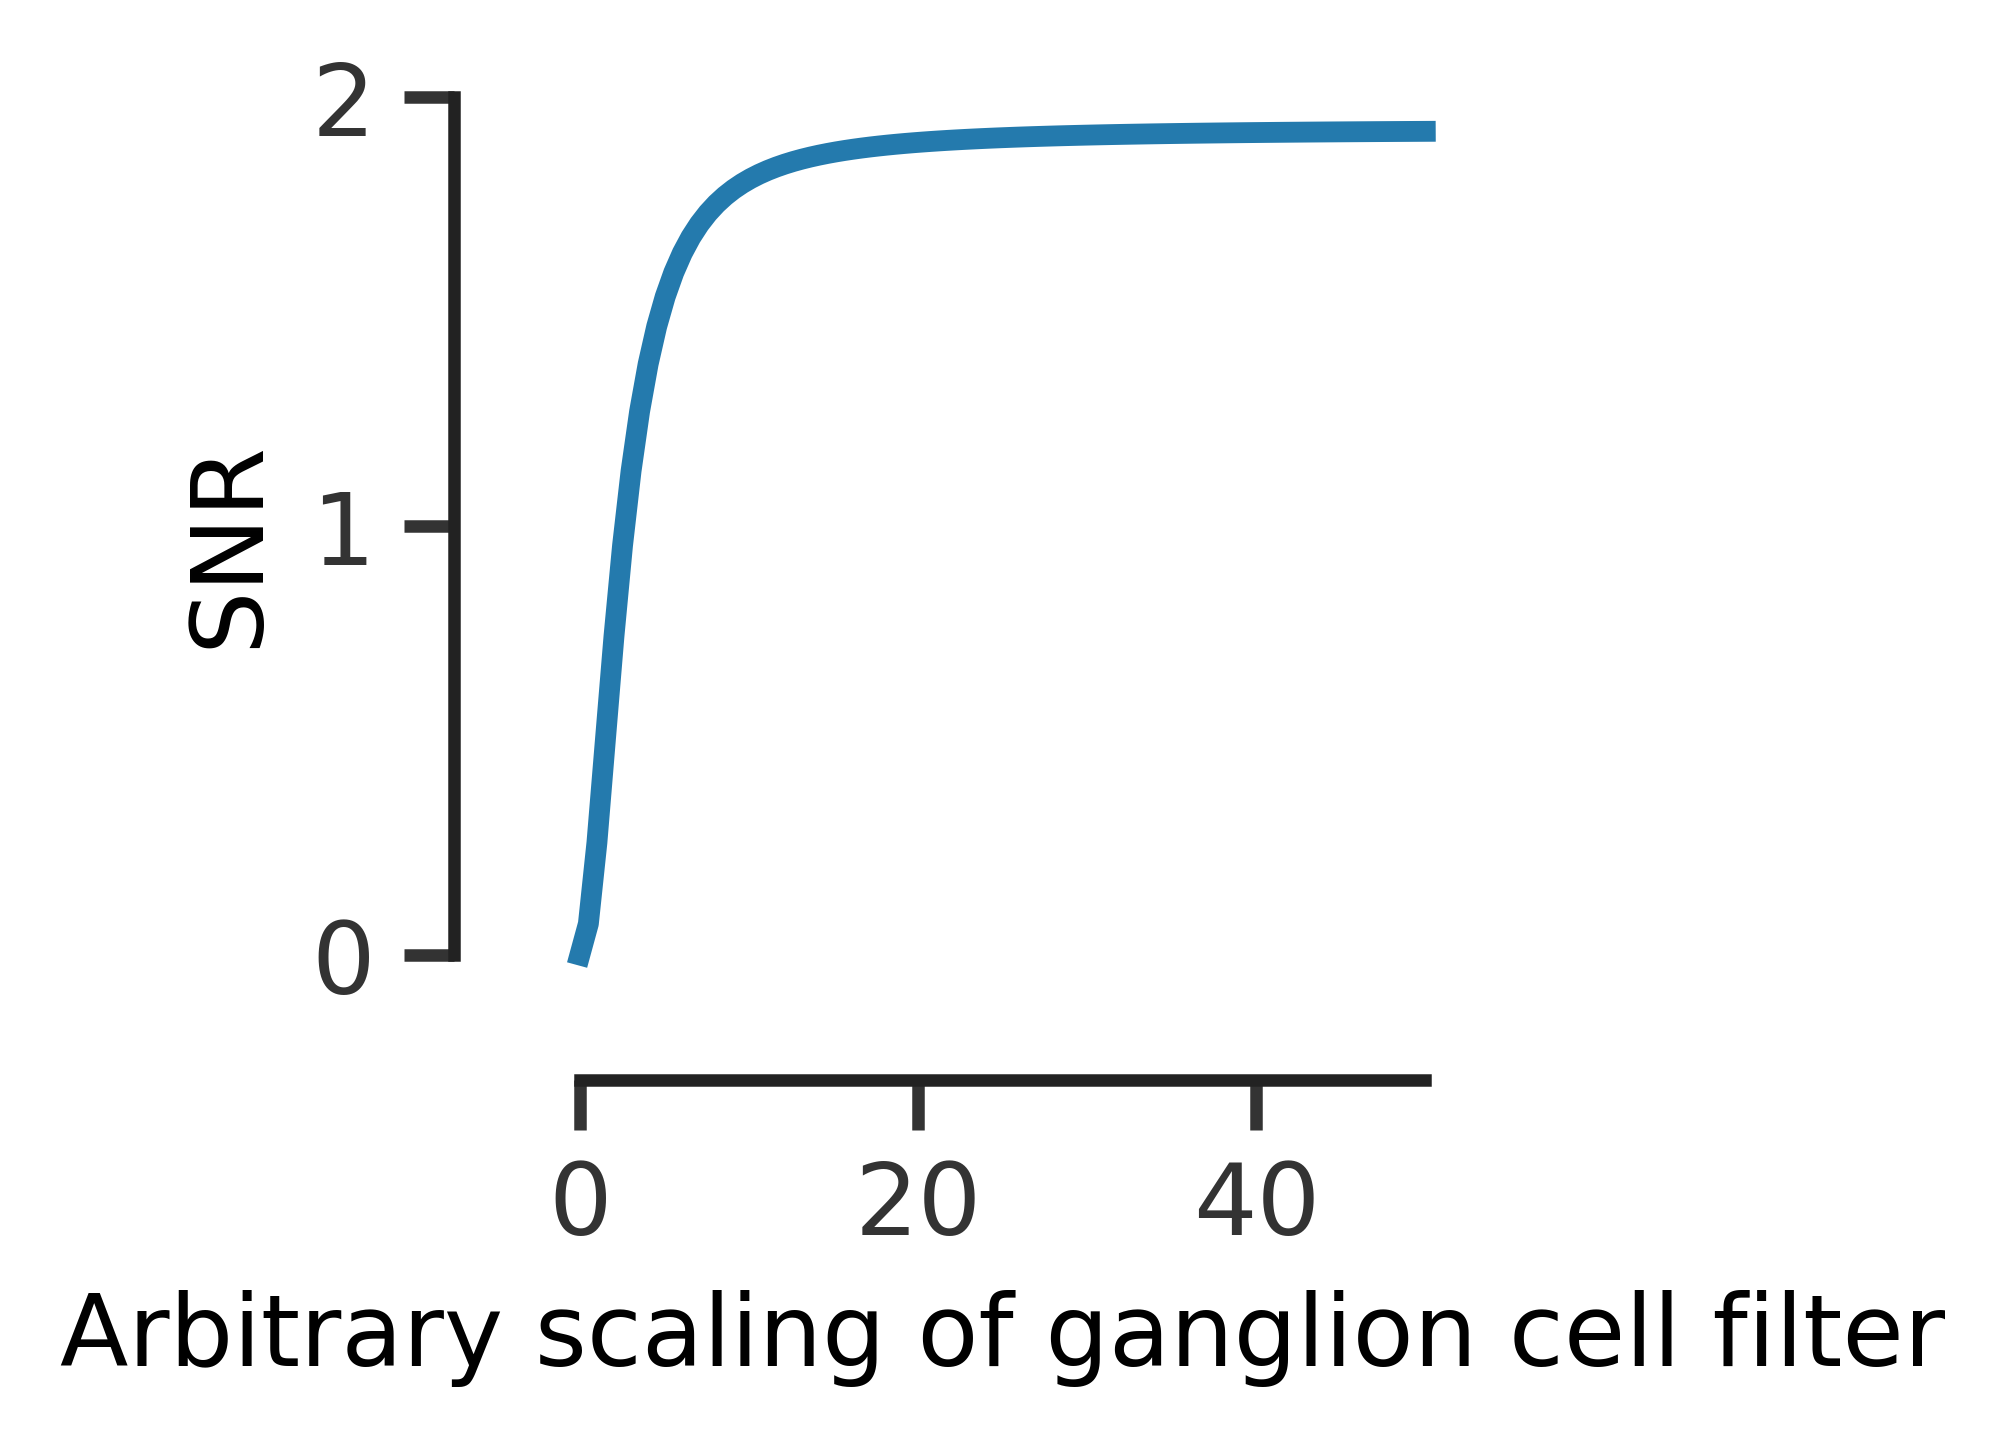

In [10]:
fig = plt.gcf()
fig.set_size_inches((2,2))
average_ganglion_fft = abs(np.fft.rfft(average_ganglion_rf))
print(get_snr(input_noise, output_noise, signal, 1000*average_ganglion_fft, mode='variance'))
snrs = [get_snr(input_noise, output_noise, signal, c*average_ganglion_fft) for c in np.linspace(0,50,100)]
plt.plot(np.linspace(0,50,100), snrs)
adjust_spines(plt.gca())
plt.xlabel('Arbitrary scaling of ganglion cell filter')
plt.ylabel('SNR')

In [11]:
# SNR = 0.269 is total SNR from ganglion recordings of 112 repeats to 30 seconds natural scenes
def find_filt_const(filt_const):
    this_snr = get_snr(input_noise, output_noise, signal, filt_const*average_ganglion_fft, mode='variance')
    return (this_snr - 0.26912469)**2

filt_const_opt = scipy.optimize.minimize_scalar(find_filt_const)

print(get_snr(input_noise, output_noise, signal, filt_const_opt.x*average_ganglion_fft, mode='variance'))

0.269124689452


### Ideal filter

In [12]:
ideal_filter = unique_soln(signal**2, input_noise, output_noise)

The relative error from this choice of Lagrangian multiplier is 2.44689914079e-07.


### Model of Horizontal Projective Field + Amacrine Projective Field + Center

In [13]:
horz_pf /= np.sum(horz_pf)
ama_pf /= np.sum(ama_pf)

Load David's 1721 ganglion cells

In [14]:
data_path = expanduser('~/data/kastner/receptive_fields/')
spatialDelta = 0.05 # mm
micronsPerDeg = 50.
ganglion_rfs = {
    'fast_on': np.loadtxt(data_path + 'linesRF1.txt').reshape((126, 101, -1)),
    'fast_off_adapting': np.loadtxt(data_path + 'linesRF19.txt').reshape((-1, 101, 96)),
    'fast_off_sensitizing': np.loadtxt(data_path + 'linesRF8.txt').reshape((-1, 101, 96)),
    'medium_off_adapting': np.loadtxt(data_path + 'linesRF29.txt').reshape((-1, 101, 96)),
    'slow_off': np.loadtxt(data_path + 'linesRF17.txt').reshape((-1, 101, 96)),
}

In [15]:
for celltype in ganglion_rfs.keys():
    for rf in ganglion_rfs[celltype]:
        # since receptive fields are noisy, use PCA
        pca = PCA(n_components=2)
        pca.fit(rf)
        g_pca = pca.components_[0]

        sign_of_pc = -1 * np.sign(g_pca[abs(g_pca) == np.max(abs(g_pca))])
        this_space = get_space(g_pca, spatialDelta, micronsPerDeg, kind='peak')
        
        rf_interp = interp1d(this_space, sign_of_pc*g_pca, kind='slinear', bounds_error=False, fill_value=[0])

        receptive_fields[celltype].append(rf_interp(space))

Get center widths for each celltype

In [16]:
diff_of_gauss_mu0 = partial(difference_of_gaussians, mu=0)

In [17]:
def center_and_surround(space, center_width, surround_width, center_strength, surround_strength):
    return diff_of_gauss_mu0(space, abs(center_width), abs(surround_width),
                            -abs(center_strength), abs(surround_strength))

In [18]:
center_widths = collections.defaultdict(list)
surround_widths = collections.defaultdict(list)
center_strengths = collections.defaultdict(list)
surround_strengths = collections.defaultdict(list)
fit_failures = collections.defaultdict(list)

for celltype in receptive_fields.keys():
    if celltype in ['ganglion', 'fast_on', 'fast_off_adapting', 'fast_off_sensitizing', 
                    'medium_off_adapting', 'slow_off']:
        
        for idg, g in tqdm(enumerate(receptive_fields[celltype])):
            try:
                popt_this, pcov = curve_fit(center_and_surround, space, g, p0=[1.5, 3.5, -10, 30])
                center_id = np.argmin(abs(popt_this[:2]))
                surround_id = 1 ^ center_id
                center_widths[celltype].append(abs(popt_this[center_id]))
                surround_widths[celltype].append(abs(popt_this[surround_id]))
                center_strengths[celltype].append(popt_this[center_id+2])
                surround_strengths[celltype].append(popt_this[surround_id+2])
#                 plt.plot(space, diff_of_gauss_mu0(space, *popt_this), color=np.random.rand(3), alpha=0.6)
            except:
                fit_failures[celltype].append(idg)
            
                # just set params to median across cells
                # this way the params are still aligned with the receptive field id
                center_widths[celltype].append(np.median(center_widths[celltype]))
                surround_widths[celltype].append(np.median(surround_widths[celltype]))
                center_strengths[celltype].append(np.median(center_strengths[celltype]))
                surround_strengths[celltype].append(np.median(surround_strengths[celltype]))
                
#                 print("Couldn't fit cell %d" %idg)

772it [01:34, 11.70it/s]
253it [01:51,  5.42it/s]
321it [00:49,  8.50it/s]
249it [00:55,  5.97it/s]
28it [00:09,  1.13it/s]
126it [00:32,  5.31it/s]


In [19]:
for f in fit_failures.keys():
    print("couldn't fit %d in %s" %(len(fit_failures[f]), f))

couldn't fit 31 in slow_off
couldn't fit 7 in medium_off_adapting
couldn't fit 5 in fast_on
couldn't fit 4 in fast_off_adapting
couldn't fit 5 in fast_off_sensitizing
couldn't fit 3 in ganglion


Plot the average profile across celltypes

In [20]:
median_center_widths = {}
for celltype in center_widths.keys():
    cws = np.array(center_widths[celltype])
    sws = np.array(surround_widths[celltype])
    css = np.array(center_strengths[celltype])
    sss = np.array(surround_strengths[celltype])
#     mean_center_widths[celltype] = np.mean(cws[cws < 500])
#     mean_surround_width = np.mean(sws[sws < 500])
#     mean_center_strength = np.mean(css[abs(css) < 500])
#     mean_surround_strength = np.mean(sss[abs(sss) < 500])
    
    median_center_widths[celltype] = np.median(abs(cws))
    median_surround_width = np.median(abs(sws))
    median_center_strength = np.median(-abs(css))
    median_surround_strength = np.median(abs(sss))
#     plt.plot(space, diff_of_gauss_mu0(space, median_center_widths[celltype], median_surround_width,
#                                      median_center_strength, median_surround_strength), label=celltype)
# plt.legend(frameon=False, fontsize=9, loc='lower left')
# adjust_spines(plt.gca())

In [21]:
median_center_widths

{'fast_off_adapting': 1.6921005209471627,
 'fast_off_sensitizing': 2.0511624440316076,
 'fast_on': 1.9647399410647877,
 'ganglion': 1.3731413963691115,
 'medium_off_adapting': 1.5794333469897559,
 'slow_off': 1.5642116399679997}

Bar charts to visualize diversity

## Run info maps

In [22]:
resolution = 150
horz_weights = np.linspace(0,1,resolution)
center_weights = np.linspace(0,1,resolution)

In [23]:
init_filt_const = 10.9
info_maps = collections.defaultdict(list) # one info map per celltype (since they will be a function of center width)
failures = collections.defaultdict(list)
detailed_failures = collections.defaultdict(list)
for celltype in receptive_fields.keys():
    if celltype in ['ganglion', 'fast_on', 'fast_off_adapting', 'fast_off_sensitizing', 
                    'medium_off_adapting', 'slow_off']:
        center = gaussian(x=space, sigma=median_center_widths[celltype], mu=0.)
        center /= -np.sum(center) # make center unit vector like horz_pf and ama_pf
        
        def rf_model(horz_weight, center_weight):
            return center_weight*center + (1-center_weight)*(horz_weight*horz_pf + (1-horz_weight)*ama_pf)
        
#         print('Information map for %s cells.' %celltype)
        
        infomap = np.zeros((resolution, resolution))
        for idh,hw in tqdm(enumerate(horz_weights)):
            for idc,cw in enumerate(center_weights):
                rf = rf_model(hw, cw)
                rf_filt = abs(np.fft.rfft(rf))
                
                # constrain model
                def constrain_filt_power(filt_const):
                    size = len(rf_filt)
                    output_power = np.sum((signal*filt_const*rf_filt)**2 
                                          + (input_noise*filt_const*rf_filt)**2
                                          + output_noise**2)
                    
                    return (target_power - output_power)**2

                filt_const_opt = scipy.optimize.minimize(constrain_filt_power, init_filt_const)
                iterations = 0
                new_init_filt_const = init_filt_const
                while not filt_const_opt.success:
                    iterations += 1
                    new_init_filt_const *= 10
                    filt_const_opt = scipy.optimize.minimize(constrain_filt_power, new_init_filt_const)
                    if iterations > 10:
                        detailed_failures[celltype] = filt_const_opt
                        break
                
                filt_const = abs(filt_const_opt['x'])
                
                if not filt_const_opt.success:
                    failures[celltype].append([hw, cw])

                signal_power = (filt_const * rf_filt * signal)**2
                noise_power = (filt_const * rf_filt * input_noise)**2 + output_noise**2
                infomap[idh,idc] = 0.5*np.sum(np.log2(1 + signal_power/noise_power))
        info_maps[celltype] = infomap

150it [00:31,  4.85it/s]
150it [00:31,  4.81it/s]
150it [00:31,  4.90it/s]
150it [00:31,  4.76it/s]
150it [00:31,  4.83it/s]
150it [00:31,  4.81it/s]


## Fit cells to rf_model

In [24]:
colorscheme = {
    'ganglion': 'k',
    'fast_off_sensitizing': 'r',
    'fast_off_adapting': 'g',
    'slow_off': 'y',
    'fast_on': 'b',
    'medium_off_adapting': 'c'
}

## Fit cells

In [ ]:
iterations = 25

fits = collections.defaultdict(list)
mean_squared_errors = collections.defaultdict(list)
abs_errors = collections.defaultdict(list)
variances = collections.defaultdict(list)

for celltype in receptive_fields.keys():
    if celltype in ['ganglion', 'fast_on', 'fast_off_adapting', 'fast_off_sensitizing', 
                    'medium_off_adapting', 'slow_off']: 
                
        popts = []
        
#         print('Fitting ganglion celltype %s.' %celltype)
        for i,rf in tqdm(enumerate(receptive_fields[celltype])):

            def rf_model(width, mean, horz_weight, center_weight):
                horz_weight = np.min([1.0, abs(horz_weight)])
                center_weight = np.min([1.0, abs(center_weight)])
                
                center = gaussian(x=space, sigma=abs(width), mu=mean)
                center /= -np.sum(center) # make center unit vector like horz_pf and ama_pf
                
                return center_weight*center + (1-center_weight)*(horz_weight*horz_pf + (1-horz_weight)*ama_pf)
            
            def model_error_to_ganglion_cells(weights):
                width, mean = weights[:2]
                hw, cw = weights[-2:]
                modeled_rf = rf_model(width, mean, hw, cw)
                normed_rf = np.max(abs(rf))*modeled_rf/np.max(abs(modeled_rf))
                return sum(abs(normed_rf - rf))

            best_fit_err = np.inf
            for itr in range(iterations):
                this_popt = minimize(model_error_to_ganglion_cells, np.hstack([center_widths[celltype][i],
                                                                               0.01,
                                                                               np.random.rand(2)]))
                if this_popt.fun < best_fit_err:
                    best_fit_err = this_popt.fun
                    popt = this_popt
            
            # get mean squared error
            modeled_rf = rf_model(*popt.x)
            normed_rf = np.max(abs(rf))*modeled_rf/np.max(abs(modeled_rf))
            mse = np.mean((normed_rf - rf)**2)

            # truncate params between 0 and 1
#             x = np.where(popt.x < 0, 0, popt.x) # this actually is wrong, since I'm abs(params) in rf_model
#             x = np.where(x > 1, 1, x)
            x = np.where(abs(popt.x) > 1, 1, abs(popt.x))

            popts.append(x)
            abs_errors[celltype].append(popt.fun)
            mean_squared_errors[celltype].append(mse)
            variances[celltype].append(np.var(rf))

        fits[celltype] = np.stack(popts)


0it [00:00, ?it/s]
80it [32:00, 23.54s/it]/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:22: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:22: RuntimeWarning: invalid value encountered in true_divide
89it [35:27, 23.64s/it]/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:22: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:22: RuntimeWarning: invalid value encountered in true_divide
134it [53:53, 23.29s/it]